In [1]:
import controllers
import controlpy
import control_utils
import dynamics_models
import numpy as np
import matplotlib.pyplot as plt
import polytope
import tqdm
import uncertainty_utils

## Setup Drone Dynamics

In [36]:
# Dynamics Parameters
n_states = 6
n_inputs = 2
dt = 0.1
m = 0.5
l = 0.4
I = (1 / 3) * m * (l**2)
init_state = np.array([3,3,0,.3,.3,0])
linearization_state = np.zeros(6)
state_limits = polytope.box2poly([[-2,4],[-2,4],[-np.pi/3, np.pi/3]])
u_min = -.01
u_max = 5
input_limits = polytope.box2poly([[u_min,u_max], [u_min,u_max]])
input_bounds = [np.array([u_min, u_min]), np.array([u_max, u_max])]
offset = m * dynamics_models.GRAVITY / 2

# Control Task
Q = np.diag([10,10,1,1,1,1])
R = np.eye(n_inputs)

# Noise and Disturbances
process_noise_var = 1e-3
process_noise = process_noise_var * np.eye(n_states)
t = uncertainty_utils.calc_t(0.95, n_states)
# disturbance_set = uncertainty_utils.get_elipse(t, process_noise, np.zeros(n_states))
db = t * np.sqrt(process_noise_var)
disturbance_bound = polytope.box2poly([[-db, db]] * n_states)

# Experiment Details
episode_length = int(5 / dt)
controller_horizon = 10
state_reference = np.zeros(n_states)
A_state = np.hstack((state_limits.A, np.zeros((state_limits.A.shape[0],3))))
state_constraints = (A_state, state_limits.b)
input_constraints = (input_limits.A, input_limits.b)

# Vehicle
def get_vehicle():
    vehicle = dynamics_models.PlanarQuadrotor(init_state, m, l , I, dt, process_noise)
    return vehicle

def sim_traj(vehicle, controller, input_limits, episode_length=episode_length, linearize=False):
    x_traj = [vehicle.x]
    u_traj = []
    
    x_pred_trajs = []
    u_pred_trajs = []

    for _ in tqdm.tqdm(range(episode_length)):
        u_command = controller.solve(x_traj[-1])
        if u_command is None:
            print("controller error at iteration %d" %_)
            break
        if linearize:
            A, B, C = control_utils.linearize_around(vehicle, controller.x_traj.value, controller.u_traj.value, dt)
            controller.set_models(A,B,C)
        u = np.minimum(np.maximum(input_limits[0], u_command), input_limits[1])
        x_next = vehicle.f(u)

        x_traj.append(x_next)
        u_traj.append(u)
        
        x_pred_trajs.append(controller.x_traj.value.T)
        u_pred_trajs.append(controller.u_traj.value.T)
        
    return np.array(x_traj), np.array(u_traj), x_pred_trajs, u_pred_trajs

## Run initial Iteration, Tracking MPC

In [37]:
vehicle = get_vehicle()
A, B, C = vehicle.get_linearization(linearization_state, np.array([offset, offset]) / 2, dt)
controller = controllers.LTI_MPC_Tracker(A, B, C,
                                         controller_horizon, 
                                         Q, R, state_reference, 
                                         state_constraints, input_constraints)
controller.build()

In [38]:
x_init_traj, u_init_traj, x_init_preds, u_init_preds = sim_traj(vehicle, controller, input_bounds)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.25it/s]


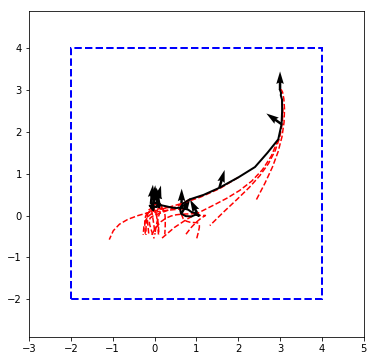

In [39]:
k = 5
lims = (-3,5)
lw = 2
state_proj = state_limits.project(np.arange(2) + 1)
plt.figure(figsize=(6,6))
plt.axis("equal")
plt.xlim(lims)
plt.ylim(lims)

ax = plt.gca()
state_proj.plot(ax=ax, alpha=1, color="w", edgecolor="b", linewidth=lw)
for x_pred in x_init_preds[::3]:
    plt.plot(x_pred[:,0], x_pred[:,1], "r--")
plt.plot(x_init_traj[:,0], x_init_traj[:,1], "k-", linewidth=lw)

plt.quiver(x_init_traj[::k,0], x_init_traj[::k,1], - np.sin(x_init_traj[::k,2]),   np.cos(x_init_traj[::k,2]))

## Setup LTI style LMPC

In [27]:
num_episodes = 10
controller = controllers.LTI_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, 
                                     state_constraints, input_constraints)
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
value_function = control_utils.compute_traj_cost(x_init_traj[:-1,:].T, u_init_traj.T, h)
controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [28]:
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds = sim_traj(vehicle, controller, input_bounds)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)

  8%|██████▋                                                                            | 4/50 [00:00<00:07,  5.78it/s]

controller error at iteration 4



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.25it/s]


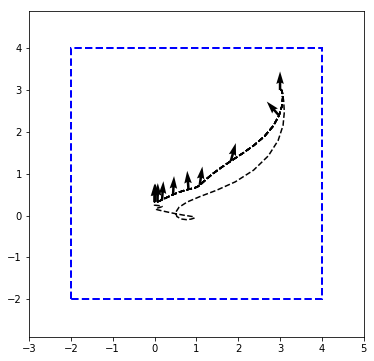

In [29]:
k = 5
lims = (-3,5)
lw = 2
state_proj = state_limits.project(np.arange(2) + 1)
plt.figure(figsize=(6,6))
plt.axis("equal")
plt.xlim(lims)
plt.ylim(lims)

ax = plt.gca()
state_proj.plot(ax=ax, alpha=1, color="w", edgecolor="b", linewidth=lw)

for x_traj in controller.traj_list:
    plt.plot(x_traj[0,:], x_traj[1,:], "k--")

x_traj = controller.traj_list[-1].T
plt.quiver(x_traj[::k,0], x_traj[::k,1], - np.sin(x_traj[::k,2]),   np.cos(x_traj[::k,2]))

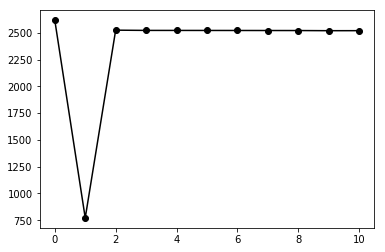

In [30]:
lti_costs = [q[0] for q in controller.value_func_list]
plt.plot(lti_costs, "k-o")

## LTV LMPC

In [6]:
num_episodes = 10
controller = controllers.LTV_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, 
                                     state_constraints, input_constraints)
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
value_function = control_utils.compute_traj_cost(x_init_traj[:-1,:].T, u_init_traj.T, h)
controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [32]:
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds = sim_traj(vehicle, controller, input_bounds, linearize=True)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)

  8%|██████▋                                                                            | 4/50 [00:00<00:08,  5.40it/s]

controller error at iteration 4



 32%|██████████████████████████▏                                                       | 16/50 [00:03<00:06,  5.32it/s]

controller error at iteration 16



 16%|█████████████▎                                                                     | 8/50 [00:01<00:07,  5.51it/s]

controller error at iteration 8



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.59it/s]


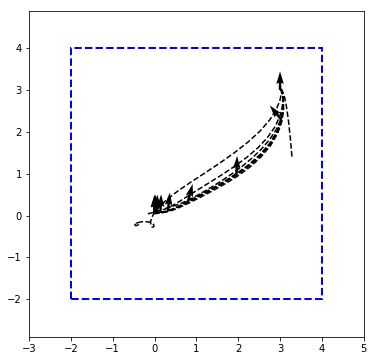

In [33]:
k = 5
lims = (-3,5)
lw = 2
state_proj = state_limits.project(np.arange(2) + 1)
plt.figure(figsize=(6,6))
plt.axis("equal")
plt.xlim(lims)
plt.ylim(lims)

ax = plt.gca()
state_proj.plot(ax=ax, alpha=1, color="w", edgecolor="b", linewidth=lw)

for x_traj in controller.traj_list[3:]:
    plt.plot(x_traj[0,:], x_traj[1,:], "k--")

x_traj = controller.traj_list[-1].T
plt.quiver(x_traj[::k,0], x_traj[::k,1], - np.sin(x_traj[::k,2]),   np.cos(x_traj[::k,2]))

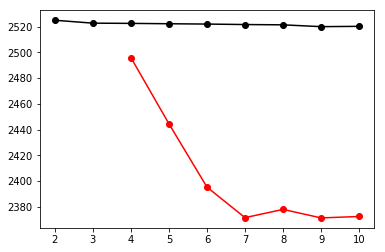

In [40]:
ltv_costs = [q[0] for q in controller.value_func_list]
lti_costs_inf = np.hstack(([np.NaN] * 2,lti_costs[2:]))
ltv_costs_inf = np.hstack(([np.NaN] * 4,ltv_costs[4:]))
plt.plot(lti_costs_inf, "k-o")
plt.plot(ltv_costs_inf, "r-o")

## LTI Tube LMPC
Don't RUN! COMPUTING MINIMAL INVARIANTS IN HIGH DIM IS NOT REALISTIC WITHOUT A PROPER FAST APPROXIMATION. It takes forever both in Matlab and in my python implementation, which largely uses the same methods as the MPT toolbox. Many projects that do control for "high" dimensional systems (i.e. n > 3) run into this problem. For example in [^1], they just subtract the disturbance set from the constraint sets to compute constraint tightenings... I'm sure there are a bunch of approximations that exist but they'll make things more conservative and/or also won't really be invariant. 

[^1]: A. Aswani, P. Bouffard, C. Tomlin, Extensions of Learning-Based Model Predictive Control for Real-Time
Application to a Quadrotor Helicopter

In [7]:
# num_episodes = 10

# controller = controllers.LTI_Tube_LMPC(A, B, C,
#                                      controller_horizon, 
#                                      Q, R, state_reference, 
#                                      state_constraints, input_constraints, 
#                                     (disturbance_bound.A, disturbance_bound.b))
# h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
# value_function = control_utils.compute_traj_cost(x_init_traj[:-1,:].T, u_init_traj.T, h)
# controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [8]:
# for episode in range(num_episodes):
#     vehicle = get_vehicle()
#     x_traj, u_traj, x_preds, u_preds = sim_traj(vehicle, controller, input_bounds)
#     value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
#     controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)

## LTI MPC

In [40]:
controller = controllers.LTI_MPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, 
                                     state_constraints, input_constraints)
controller.build()

In [41]:
X = polytope.Polytope(*state_constraints)
U = polytope.Polytope(*input_constraints)
K, _, _ = controlpy.synthesis.controller_lqr_discrete_time(A, B, Q, R)
O = control_utils.maximal_invariant(X, A, B=B, K=K, U=U)

In [42]:
vehicle = get_vehicle()
x_traj, u_traj, x_preds, u_preds = sim_traj(vehicle, controller, input_bounds)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.64it/s]


(-3, 5)

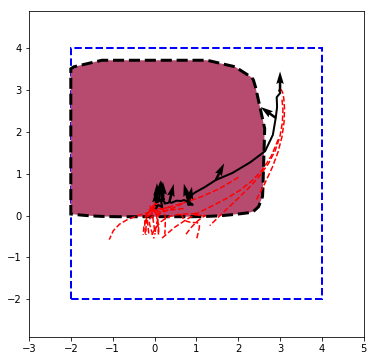

In [43]:
plt.figure(figsize=(6,6))
ax = plt.gca()
Op = O.project([1,2])
state_proj.plot(ax=ax, alpha=1, color="w", edgecolor="b", linewidth=lw)

for x_pred in x_init_preds[::3]:
    plt.plot(x_pred[:,0], x_pred[:,1], "r--")
plt.plot(x_traj[:,0], x_traj[:,1], "k-", linewidth=lw)

plt.quiver(x_traj[::k,0], x_traj[::k,1], - np.sin(x_traj[::k,2]),   np.cos(x_traj[::k,2]))
Op.plot(ax=ax)
plt.axis("equal")
plt.xlim(lims)
plt.ylim(lims)